# Training and saving a model. 


In [1]:
from model import Generator, Discriminator
from latent_learner import LatentLearner
from dataset import Dataset
from tqdm import tqdm
import loss
import random
import utils
import torch
import torchvision

import numpy as np

import gc
import os

/home/ceng796/miniconda3/envs/796/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train(device, max_iters=150):
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    generator = Generator(size=256, style_dim=512, n_mlp=8).to(device)
    discriminator = Discriminator(size=256).to(device)
    latent_learner = LatentLearner().to(device)

    vgg = torchvision.models.vgg19(weights='IMAGENET1K_V1').features.to(device).eval()

    # No need for gradients on the parameters of these
    utils.disable_grad(generator)
    utils.disable_grad(vgg)

    # Take sub-networks from the vgg, later used to compute style loss
    subnetworks = loss.subnetworks(vgg, max_layers=5)

    # Garbage collection
#    del vgg
#    gc.collect()
#    torch.cuda.empty_cache()

    # Load checkpoint and weights
    ckpt = torch.load("550000.pt")

    generator.load_state_dict(ckpt["g_ema"], strict=False)
    generator.eval()

    discriminator.load_state_dict(ckpt["d"])

    # Initialize optimizers (no optimizer for generator :)
    disc_opt = torch.optim.Adam(
        discriminator.parameters(),
        lr = 5e-4,
        betas = (0.0, 0.99)
    )
    latent_learner_opt = torch.optim.Adam(
        latent_learner.parameters(),
        lr = 5e-4,
        betas = (0.0, 0.99)
    )

    # Simple transformation pipeline
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256, 256)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # style loss normalization
    style_norm = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Create simple dataset & loader
    #x = torch.randn(10, 14, 1024, device=device)

    dataset = Dataset(path="./babies", transforms=transforms)

    bar = tqdm(range(max_iters), dynamic_ncols=True)

    # 150 iterations
    for iter_ in bar:
        idx = np.random.choice(10, size=4, replace=False)

        imgs, latents = dataset[idx]
        imgs, latents = imgs.to(device), latents.to(device)

        ##### Adversarial Loss ##### 
        # first forward pass
        w = latent_learner(latents)
        samples, _ = generator([w], input_is_latent=True)

        real_scores = discriminator(imgs)
        fake_scores = discriminator(samples)

        d_loss = loss.d_logistic_loss(real_scores, fake_scores)

        # optimization step on discriminator
        disc_opt.zero_grad()
        d_loss.backward()
        disc_opt.step()

        # second forward pass (needed)
        w = latent_learner(latents)
        samples, _ = generator([w], input_is_latent=True)

        fake_scores = discriminator(samples)

        g_loss = 5 * (1 - iter_/max_iters) * loss.g_nonsaturating_loss(fake_scores)

        # optimization step on latent learner
        latent_learner_opt.zero_grad()
        g_loss.backward()
        latent_learner_opt.step()

        ##### Style Loss #####
        idx = np.random.choice(10, size=5, replace=False)

        imgs, latents = dataset[idx]
        imgs, latents = imgs.to(device), latents.to(device)

        w = latent_learner(latents)

        samples, _ = generator([w], input_is_latent=True)

        style_loss = 50 * loss.style_loss(subnetworks, style_norm(imgs), style_norm(samples))

        latent_learner_opt.zero_grad()
        style_loss.backward()
        latent_learner_opt.step()

        bar.set_description(f"d_loss: {d_loss.cpu():.2f}, g_loss: {g_loss.cpu():.2f}, style_loss: {style_loss:.2f}")

        if (iter_+1) % 50 == 0:
#            save_samples(x_1, x_2, generator, latent_learner, iter_+1)
            utils.save_samples(dataset.x.to(device), generator, latent_learner, iter_+1)

#    return torch.cat([x_1, x_2], axis=-1), latent_learner, generator
    return dataset.x.to(device), latent_learner, generator

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
noise, latent_learner, generator = train(device, max_iters=50)

d_loss: 0.08, g_loss: 0.38, style_loss: 0.95: 100%|█████████████████████████████████████| 50/50 [00:46<00:00,  1.07it/s]


In [5]:
os.makedirs("ckpts", exist_ok=True)

torch.save(noise, "ckpts/noise.pt")
torch.save(latent_learner.state_dict(), "ckpts/latent_learner.pt")
torch.save(generator.state_dict(), "ckpts/generator.pt")

# Loading a pre-trained model and computing qualitative samples/outputs from that model

In [6]:
generator = Generator(size=256, style_dim=512, n_mlp=8).to(device)
generator.load_state_dict(torch.load("ckpts/generator.pt"))
generator.eval()

latent_learner = LatentLearner().to(device)
latent_learner.load_state_dict(torch.load("ckpts/latent_learner.pt"))

noise = torch.load("ckpts/noise.pt")

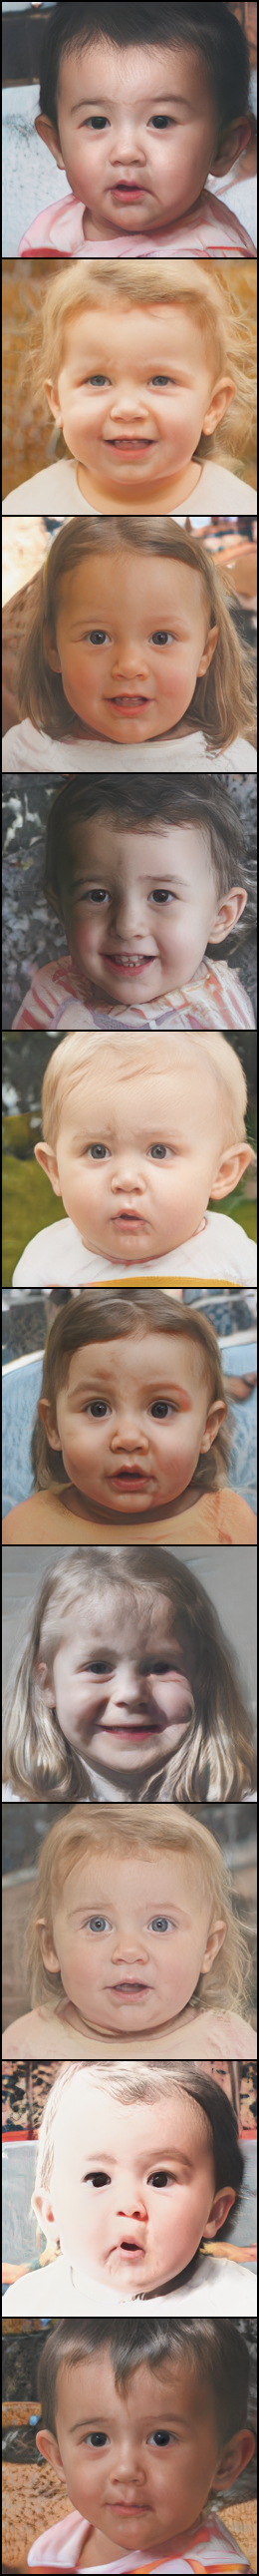

In [7]:
with torch.no_grad():
    # Map to latent
    w = latent_learner(noise)

    # Pass through Generator
    samples, _ = generator([w], input_is_latent=True)

    # Save for later examination
    torchvision.utils.save_image(
        samples.detach(),
        "samples.png",
        nrow=1,
        normalize=True,
        range=(-1, 1),
    )

    from PIL import Image

    display(Image.open("samples.png"))